In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [8]:
pip install pandas_datareader

Note: you may need to restart the kernel to use updated packages.


In [9]:
from pandas_datareader import data as pdr

In [32]:
df = pdr.get_data_yahoo('SPY','2012-01-01','2017-01-01')
df = df.dropna()
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,128.380005,127.430000,127.760002,127.500000,193697900.0,107.134926
2012-01-04,127.809998,126.709999,127.199997,127.699997,127186500.0,107.302979
2012-01-05,128.229996,126.430000,127.010002,128.039993,173895000.0,107.588661
2012-01-06,128.220001,127.290001,128.199997,127.709999,148050000.0,107.311371
2012-01-09,128.179993,127.410004,128.000000,128.020004,99530200.0,107.571877


In [33]:
tmp_df = df[['Open','High','Low','Close']].copy()
tmp_df.head()

,Open,High,Low,Close
Date,,,,
2012-01-03,127.760002,128.380005,127.430000,127.500000
2012-01-04,127.199997,127.809998,126.709999,127.699997
2012-01-05,127.010002,128.229996,126.430000,128.039993
2012-01-06,128.199997,128.220001,127.290001,127.709999
2012-01-09,128.000000,128.179993,127.410004,128.020004


In [34]:
tmp_df['Open-Close'] = tmp_df['Open'] - tmp_df['Close']
tmp_df['High-Low'] = tmp_df['High'] - tmp_df['Low']
tmp_df = tmp_df.dropna()
X = tmp_df[['Open-Close','High-Low']]
# SPY지수가 오르면 매수 내리면 매도 신호
y = np.where(tmp_df['Close'].shift(-1) > tmp_df['Open'].shift(-1),1,-1)
X.head()

,Open-Close,High-Low
Date,,
2012-01-03,0.260002,0.950005
2012-01-04,-0.500000,1.099998
2012-01-05,-1.029991,1.799995
2012-01-06,0.489998,0.930000
2012-01-09,-0.020004,0.769989


In [35]:
split_percentage = 0.7
split = int(split_percentage*len(tmp_df))
X_train = X[:split]
y_train = y[:split]
X_test = X[split:]
y_test = y[split:]

In [36]:
train_acc = []
test_acc = []

for n in range(1,15):
    clf = KNeighborsClassifier(n_jobs=-1,n_neighbors=n)
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    train_acc.append(clf.score(X_train,y_train))
    test_acc.append((y_pred==y_test).mean())

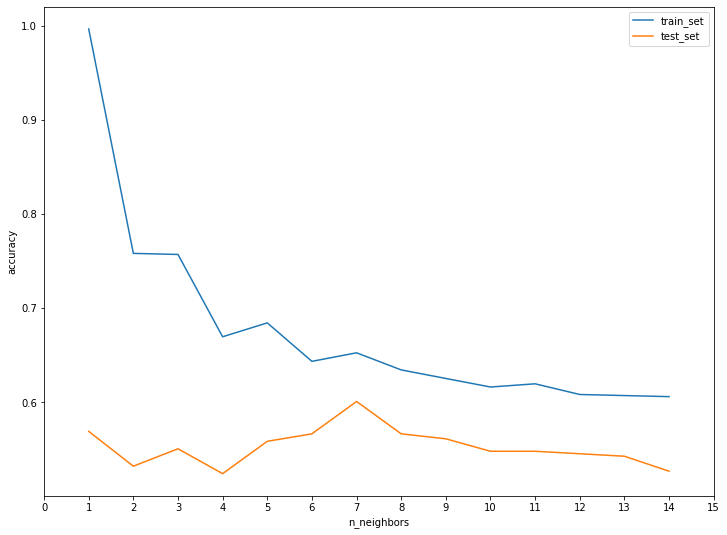

In [39]:
plt.figure(figsize=(12,9))
plt.plot(range(1,15),train_acc,label='train_set')
plt.plot(range(1,15),test_acc,label='test_set')
plt.xlabel('n_neighbors')
plt.ylabel('accuracy')
plt.xticks(np.arange(0,16,step=1))
plt.legend()
# K가 7일 때 테스트셋의 성능이 가장좋음

In [41]:
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train,y_train)

acc_train = accuracy_score(y_train,knn.predict(X_train))
acc_test = accuracy_score(y_test,knn.predict(X_test))
print('훈련 정확도: %.2f'%acc_train)
print('테스트 정확도: %.2f'%acc_test)

훈련 정확도: 0.65
테스트 정확도: 0.60


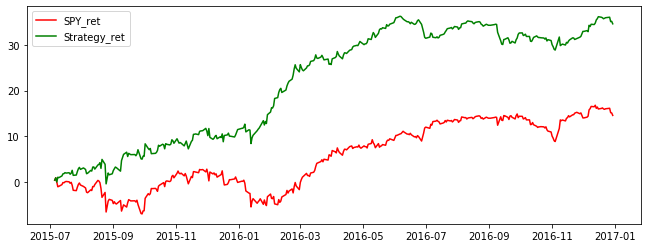

누적 S&P500 수익률: 14.58
누적 전략 수익률: 34.57


In [72]:
tmp_df['Predicted_Signal'] = knn.predict(X)

#누적 S&P500 수익률
tmp_df['SPY_ret'] = np.log(tmp_df['Close']/tmp_df['Open'])
cum_spy_ret = tmp_df[split:]['SPY_ret'].cumsum()*100

#누적 전략 수익률
tmp_df['st_ret'] = tmp_df['SPY_ret']*tmp_df['Predicted_Signal'].shift(1)
cum_st_ret = tmp_df[split:]['st_ret'].cumsum()*100

plt.figure(figsize=(11,4))
plt.plot(cum_spy_ret,color='r',label='SPY_ret')
plt.plot(cum_st_ret,color='g',label='Strategy_ret')
plt.legend()
plt.show()
print("누적 S&P500 수익률: %.2f"%cum_spy_ret[-1])
print("누적 전략 수익률: %.2f"%cum_st_ret[-1])

In [69]:
print("Total:",tmp_df['Predicted_Signal'].count())
print('UP predict : ',tmp_df.loc[tmp_df['Predicted_Signal'] == 1,['Predicted_Signal']].count()[0])
print('DOWN predict : ',tmp_df.loc[tmp_df['Predicted_Signal'] == -1,['Predicted_Signal']].count()[0])

Total: 1258
UP predict :  779
DOWN predict :  479


In [57]:
std = cum_st_ret.std()
sharpe = (cum_st_ret - cum_spy_ret) / std
sharpe = sharpe.mean()
print('Sharpe ratio : %.2f' % sharpe)

Sharpe ratio : 1.30
